In [2]:
# Use CPU only
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import keras
import os
import numpy as np
from keras.models import load_model
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
project_dir = '/home/rabreu/projeto_multimodal/'
data_dir = project_dir+'data/'

audioset_indices_csv = project_dir+'segments/subset_class_labels_indices.csv'

## pegando dataset desbalanceado, que eu balanceei para 600 ocorrências para cada classe
audioset_train_csv = project_dir+'segments/2000max_subset_unbalanced_train_segments.csv'
audio_train_sub_dir = '2000unbalanced_train/audio'
video_train_sub_dir = '2000unbalanced_train/video'

audioset_eval_csv = project_dir+'segments/subset_eval_segments.csv'
audio_eval_sub_dir = 'eval/audio'
video_eval_sub_dir = 'eval/video'

### Carregando dados de validação

In [3]:
## audio
save_dir = data_dir+audio_eval_sub_dir+"/2000features/cnn/"
feature_file = os.path.join(save_dir+'_x.npy')
audio_eval_x = np.load(feature_file)
## eval_y are only loaded once, since they are the same for audio and video
print(audio_eval_x.shape)

audio_eval_x = np.expand_dims(audio_eval_x, axis=-1)


labels_file = os.path.join(save_dir+'_y.npy')
eval_y = np.load(labels_file)




## video
save_dir = data_dir+video_eval_sub_dir+"/features/"
feature_file = os.path.join(save_dir+'_x.npy')
video_eval_x = np.load(feature_file)

## Mapeando valores de pixels para o espaço entre 0 e 1
video_eval_x = video_eval_x.astype('float32')
video_eval_x /= 255

print(video_eval_x.shape)


(532, 60, 420)
(532, 32, 32, 32, 3)


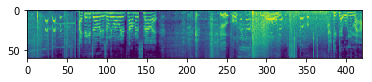

In [4]:
plt.imshow(audio_eval_x[14][:,:,-1])

## Contar quantos labels tem nos conjuntos de treino e validação


In [6]:
labels = ["Wind","Thunder","Rain","Ocean","Fire","Explosion","Gunshot, gunfire"]

def count_labels(y):
    label_count = np.zeros(y[0].shape[0])
    total_labels = 0
    for k,v in enumerate(y):
        for x,_ in enumerate(labels):
            if y[k][x] == 1:
                label_count[x] += 1
                total_labels += 1
    return y.shape[0],label_count,total_labels

def label_percentage(total_labels,label_count):
    percentage_labels = np.zeros(label_count.shape[0])
    for k,label in enumerate(label_count):
        percentage_labels[k] = round(((label*100) / total_labels),2)
    return percentage_labels

In [7]:
save_dir = data_dir+audio_train_sub_dir+"/2000features/cnn/"
labels_file = os.path.join(save_dir + '_y.npy')
train_y = np.load(labels_file)
train_y.shape

(10950, 7)

In [8]:
total_examples,label_count,total_labels = count_labels(train_y)
print('Exemplos totais',total_examples,'total_labels',total_labels)
print("Quantidade de labels para cada classe:: \n {} \n {}".format(labels,label_count))
print("Porcentagem de cada label \n {}".format(label_percentage(total_labels,label_count)))

('Exemplos totais', 10950, 'total_labels', 12829)
Quantidade de labels para cada classe:: 
 ['Wind', 'Thunder', 'Rain', 'Ocean', 'Fire', 'Explosion', 'Gunshot, gunfire'] 
 [ 2587.  1071.  2194.  1910.  1269.  1931.  1867.]
Porcentagem de cada label 
 [ 20.17   8.35  17.1   14.89   9.89  15.05  14.55]


In [9]:
total_examples,label_count,total_labels = count_labels(eval_y)
print('Exemplos totais',total_examples,'total_labels',total_labels)
print("Quantidade de labels para cada classe:: \n {} \n {}".format(labels,label_count))
print("Porcentagem de cada label \n {}".format(label_percentage(total_labels,label_count)))

('Exemplos totais', 532, 'total_labels', 657)
Quantidade de labels para cada classe:: 
 ['Wind', 'Thunder', 'Rain', 'Ocean', 'Fire', 'Explosion', 'Gunshot, gunfire'] 
 [ 173.   53.   92.   62.   60.   55.  162.]
Porcentagem de cada label 
 [ 26.33   8.07  14.     9.44   9.13   8.37  24.66]


### Carregando modelos

In [5]:
audio_model = load_model('modelos_salvos/2000audio_cnn.h5')
video_model = load_model('modelos_salvos/2000video_cnn.h5')
from utils import top_3_accuracy
multimodal_model = load_model('modelos_salvos/multimodal.h5', custom_objects={'top_3_accuracy': top_3_accuracy}) 

In [6]:
audio_history = np.load('modelos_salvos/2000audio_history.npy')
audio_metrics = np.load('modelos_salvos/2000audio_metrics.npy')

fusioned_audio_history = np.load('modelos_salvos/fusioned_audio_history.npy')
fusioned_video_history = np.load('modelos_salvos/fusioned_video_history.npy')


video_history = np.load('modelos_salvos/2000video_history.npy')
video_metrics = np.load('modelos_salvos/2000video_metrics.npy')

multimodal_history = np.load('modelos_salvos/multimodal_history.npy')
multimodal_metrics = np.load('modelos_salvos/multimodal_metrics.npy')

Qual o shape que entra no LSTM?


In [7]:
video_model.layers[-5].input_shape

(None, 32, 512)

# Predições com o novo conjunto eval

In [8]:
from utils import multilabel_confusion_matrix
n_classes = 7
labels = ["Wind","Thunder","Rain","Ocean","Fire","Explosion","Gunshot, gunfire"]

### Audio

In [9]:
predictions = audio_model.predict(audio_eval_x)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

from sklearn.metrics import hamming_loss
print("Hamming Loss:",hamming_loss(eval_y,predictions))

# "You may also want to compute the hamming score, to see whether your classifier is clueless, 
# or is instead decently good but have issue predicting all labels correctly. See below to compute the hamming score."
# https://stats.stackexchange.com/questions/233275/multilabel-classification-metrics-on-scikit/234354#234354


# a diferença entre o ground truth e predições será toda 0 quando os dois forem iguais
## Então buscamos desses não dão tudo 0 e tiramos o inverso disso
predicted_diference = eval_y-predictions
correcly_predicted = (np.where(~(predicted_diference).any(axis=1))[0])
print("Exact match:",correcly_predicted.shape[0])
print("Accuracy of Exact match:", float(correcly_predicted.shape[0])/eval_y.shape[0])

## If you want to make sure that they are really equal
#for x in correcly_predicted:
#    print np.array_equal(predictions[x], eval_y[x])

multilabel_confusion_matrix(eval_y,predictions,n_classes)

('Hamming Loss:', 0.1458109559613319)
('Exact match:', 179)
('Accuracy of Exact match:', 0.33646616541353386)
Multilabel Confusion Matrix
  TP,   FP,     TN,     FN, 
0 80	47	312	93
1 15	2	477	38
2 44	24	416	48
3 17	35	435	45
4 14	17	455	46
5 18	20	457	37
6 80	9	361	82
Σ 268	154	2913	389

F1 Score: 0.496756
Recall: 0.407915
Precision: 0.635071
Hamming Loss: 0.145811


### Video

In [10]:
predictions = video_model.predict(video_eval_x)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

from sklearn.metrics import hamming_loss
print("Hamming Loss:",hamming_loss(eval_y,predictions))

# "You may also want to compute the hamming score, to see whether your classifier is clueless, 
# or is instead decently good but have issue predicting all labels correctly. See below to compute the hamming score."
# https://stats.stackexchange.com/questions/233275/multilabel-classification-metrics-on-scikit/234354#234354


# a diferença entre o ground truth e predições será toda 0 quando os dois forem iguais
## Então buscamos desses não dão tudo 0 e tiramos o inverso disso
predicted_diference = eval_y-predictions
correcly_predicted = (np.where(~(predicted_diference).any(axis=1))[0])
print("Exact match:",correcly_predicted.shape[0])
print("Accuracy of Exact match:", float(correcly_predicted.shape[0])/eval_y.shape[0])

## If you want to make sure that they are really equal
#for x in correcly_predicted:
#    print np.array_equal(predictions[x], eval_y[x])

multilabel_confusion_matrix(eval_y,predictions,n_classes)

('Hamming Loss:', 0.17185821697099893)
('Exact match:', 168)
('Accuracy of Exact match:', 0.3157894736842105)
Multilabel Confusion Matrix
  TP,   FP,     TN,     FN, 
0 112	80	279	61
1 12	16	463	41
2 36	33	407	56
3 49	112	358	13
4 28	12	460	32
5 22	30	447	33
6 74	33	337	88
Σ 333	316	2751	324

F1 Score: 0.509954
Recall: 0.506849
Precision: 0.513097
Hamming Loss: 0.171858


### Multimodal

In [11]:
predictions = multimodal_model.predict([video_eval_x,audio_eval_x])
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

from sklearn.metrics import hamming_loss
print("Hamming Loss:",hamming_loss(eval_y,predictions))

# "You may also want to compute the hamming score, to see whether your classifier is clueless, 
# or is instead decently good but have issue predicting all labels correctly. See below to compute the hamming score."
# https://stats.stackexchange.com/questions/233275/multilabel-classification-metrics-on-scikit/234354#234354


# a diferença entre o ground truth e predições será toda 0 quando os dois forem iguais
## Então buscamos desses não dão tudo 0 e tiramos o inverso disso
predicted_diference = eval_y-predictions
correcly_predicted = (np.where(~(predicted_diference).any(axis=1))[0])
print("Exact match:",correcly_predicted.shape[0])
print("Accuracy of Exact match:", float(correcly_predicted.shape[0])/eval_y.shape[0])

## If you want to make sure that they are really equal
#for x in correcly_predicted:
#    print np.array_equal(predictions[x], eval_y[x])

multilabel_confusion_matrix(eval_y,predictions,n_classes)

('Hamming Loss:', 0.12352309344790548)
('Exact match:', 259)
('Accuracy of Exact match:', 0.4868421052631579)
Multilabel Confusion Matrix
  TP,   FP,     TN,     FN, 
0 111	53	306	62
1 28	14	465	25
2 70	44	396	22
3 41	49	421	21
4 42	24	448	18
5 21	14	463	34
6 95	13	357	67
Σ 408	211	2856	249

F1 Score: 0.639498
Recall: 0.621005
Precision: 0.659128
Hamming Loss: 0.123523


## Teste ROC

In [16]:
## audio
predictions = audio_model.predict(audio_eval_x)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
from sklearn.metrics import roc_auc_score
print "audio ROC", roc_auc_score(eval_y, predictions, average='macro', sample_weight=None)

## video
predictions = video_model.predict(video_eval_x)
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
from sklearn.metrics import roc_auc_score
print "video ROC", roc_auc_score(eval_y, predictions, average='macro', sample_weight=None)

## multimodal
predictions = multimodal_model.predict([video_eval_x,audio_eval_x])
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
from sklearn.metrics import roc_auc_score
print "multimodal ROC", roc_auc_score(eval_y, predictions, average='macro', sample_weight=None)

audio ROC 0.656139723781
video ROC 0.687989259741
multimodal ROC 0.768847880034


### Visualizando loss

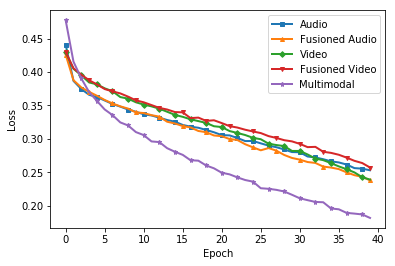

In [242]:
plt.plot(audio_history.item()['loss'],'s-',linewidth=2,markersize=4,markevery=2)
plt.plot(fusioned_audio_history.item()['loss'],'^-',linewidth=2,markersize=4,markevery=3)
plt.plot(video_history.item()['loss'],'D-',linewidth=2,markersize=4,markevery=2)
plt.plot(fusioned_video_history.item()['loss'],'v-',linewidth=2,markersize=4,markevery=3)
plt.plot(multimodal_history.item()['loss'],'*-',linewidth=2,markersize=5,markevery=2)

#plt.xlim( (0, 40) )

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Audio','Fusioned Audio', 'Video','Fusioned Video','Multimodal'], loc='upper right')
plt.savefig('loss.pdf', format="pdf")

# Keras filter visualization
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [12]:
audio_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
audio_input (InputLayer)     (None, 60, 420, 1)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 415, 80)        27440     
_________________________________________________________________
activation_29 (Activation)   (None, 4, 415, 80)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 1, 138, 80)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 1, 138, 80)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 1, 138, 80)        320       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 1, 136, 80)        19280     
__________

In [69]:
video_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
video_input (InputLayer)     (None, 32, 32, 32, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 32, 16, 16, 32)    896       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 32, 16, 16, 32)    128       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 32, 16, 16, 32)    9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 32, 16, 16, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 32, 8, 8, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 32, 8, 8, 32)      0         
__________

In [70]:
multimodal_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
video_input (InputLayer)        (None, 32, 32, 32, 3 0                                            
__________________________________________________________________________________________________
time_distributed_35 (TimeDistri (None, 32, 16, 16, 3 896         video_input[0][0]                
__________________________________________________________________________________________________
time_distributed_36 (TimeDistri (None, 32, 16, 16, 3 128         time_distributed_35[0][0]        
__________________________________________________________________________________________________
time_distributed_37 (TimeDistri (None, 32, 16, 16, 3 9248        time_distributed_36[0][0]        
__________________________________________________________________________________________________
time_distr

In [139]:
layer_dict = dict([(layer.name, layer) for layer in audio_model.layers])

from keras import backend as K

layer_name = 'conv2d_15'
filter_index = 3  # can be any integer from 0 to 511, as there are 512 filters in that layer
input_img = audio_model.input
# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
loss = K.mean(layer_output[:, :, :, filter_index])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [140]:
import numpy as np
# step size for gradient ascent
step = 1.
# we start from a gray image with some noise
input_img_data = np.random.random((1,60, 420,1)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

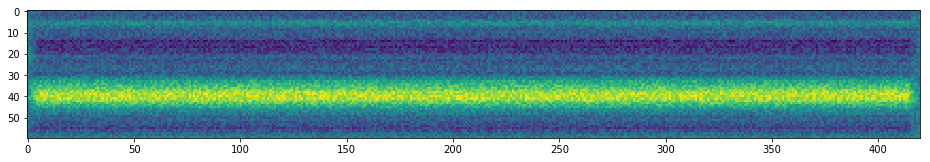

In [141]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
#img = deprocess_image(img)
plt.figure(figsize=(16,5))
plt.imshow(img[:, :, 0])


(60, 420, 1)

## Get filters

In [56]:
labels = ["Wind","Thunder","Rain","Ocean","Fire","Explosion","Gunshot, gunfire"]
len(labels)

7

In [10]:
# usar vis para visualizar ativações
#https://github.com/raghakot/keras-vis

In [11]:
from vis.visualization import visualize_activation,visualize_activation_with_losses
from vis.utils import utils
from keras import activations

In [128]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(audio_model, 'main_output')

# Swap softmax with linear
audio_model.layers[layer_idx].activation = activations.linear
audio_model = utils.apply_modifications(audio_model)

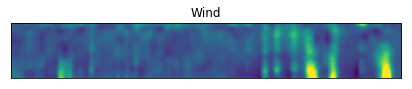

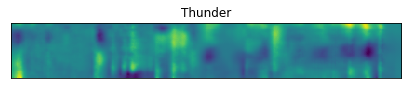

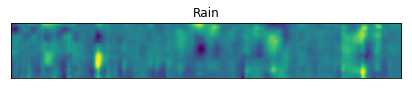

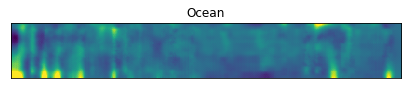

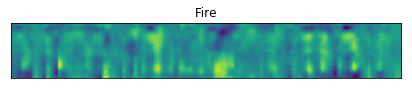

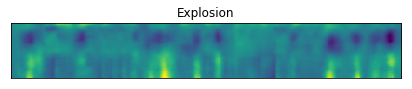

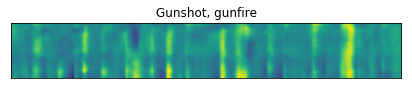

In [129]:

for x, label in enumerate(labels):
    filter_idx = x
    img = visualize_activation(audio_model, layer_idx, filter_indices=filter_idx,#max_iter=30, 
                               input_range=(0., 1.),
                                #act_max_weight = 10,
                                tv_weight=1.5, lp_norm_weight=2
                              )
    plt.figure(figsize=(7,7))
    plt.imshow(img[..., 0])
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(label))
    plt.show()

In [130]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(video_model, 'main_output')

# Swap softmax with linear
video_model.layers[layer_idx].activation = activations.linear
video_model = utils.apply_modifications(video_model)

from vis.input_modifiers import Jitter


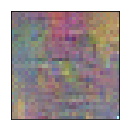

In [138]:
filter_idx = 0
img = visualize_activation(video_model, layer_idx,filter_indices=filter_idx,max_iter=500, 
                           #act_max_weight = 3, 
                           input_range=(0., 1.),
                           # tv_weight=1, #lp_norm_weight=0.,
                           tv_weight=1.5, lp_norm_weight=2,
                          # input_modifiers=[Jitter(16)]
                          )
img = img[:,:,:,::-1]
plt.figure(figsize=(2,2))
plt.xticks([])
plt.yticks([])
plt.imshow(img[5,:,:,:])

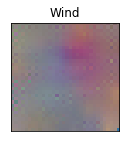

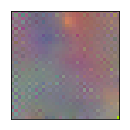

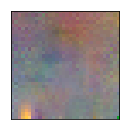

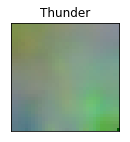

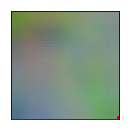

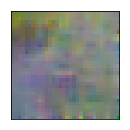

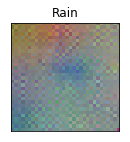

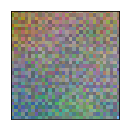

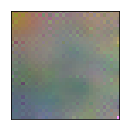

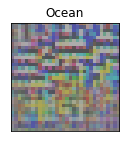

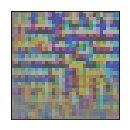

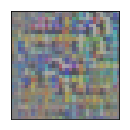

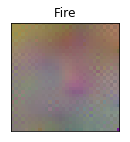

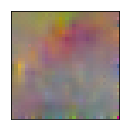

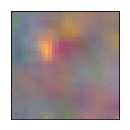

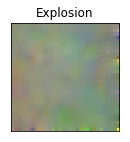

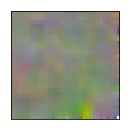

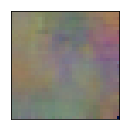

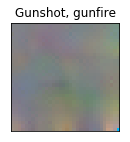

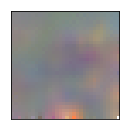

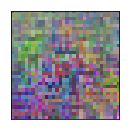

In [143]:
for x, label in enumerate(labels):
    filter_idx = x
    img = visualize_activation(video_model, layer_idx,filter_indices=filter_idx,max_iter=500, 
                               #act_max_weight = 3, 
                               input_range=(0., 1.),
                               # tv_weight=1, #lp_norm_weight=0.,
                               tv_weight=1.5, lp_norm_weight=2,
                              # input_modifiers=[Jitter(16)]
                              )
    img = img[:,:,:,::-1]
    plt.figure(figsize=(2,2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[5,:,:,:])
    plt.title('{}'.format(label))
    plt.savefig('./plots/{}1.png'.format(label))
    
    plt.figure(figsize=(2,2))
    plt.imshow(img[11,:,:,:])
    plt.xticks([])
    plt.yticks([])
    plt.savefig('./plots/{}2.png'.format(label))
    
    plt.figure(figsize=(2,2))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img[23,:,:,:])
    plt.savefig('./plots/{}3.png'.format(label))

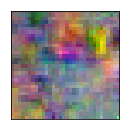

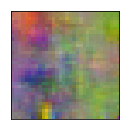

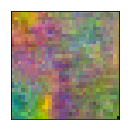

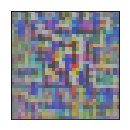

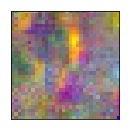

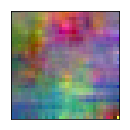

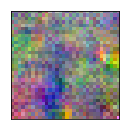

In [245]:
for x, label in enumerate(labels):
    filter_idx = x
    img = visualize_activation(video_model, layer_idx,filter_indices=filter_idx,max_iter=500, 
                               #act_max_weight = 3, 
                               input_range=(0., 1.),
                               # tv_weight=1, #lp_norm_weight=0.,
                               tv_weight=1.5, lp_norm_weight=2,
                              # input_modifiers=[Jitter(16)]
                              )
    img = img[:,:,:,::-1]
    plt.figure(figsize=(2,2))
    plt.xticks([])
    plt.yticks([])
    for y in range(0,31):
        plt.imshow(img[y,:,:,:])
        plt.savefig('./plots/gifs/{}{}.png'.format(label,y))


In [251]:
!cd plots/gifs/


2000audio_concat.ipynb			 Multimodal.ipynb
2000audio.ipynb				 nohup.out
2000video_concat.ipynb			 plots
2000video.ipynb				 requirements.txt
data					 segments
get_dataset_from_youtube.py		 somar_predicoes.ipynb
Jupyter antigos				 utils.py
KERAS-VIS_activation_maximization.ipynb  utils.pyc
loss.pdf				 venv
modelos_salvos				 viz.ipynb


## Get Activations

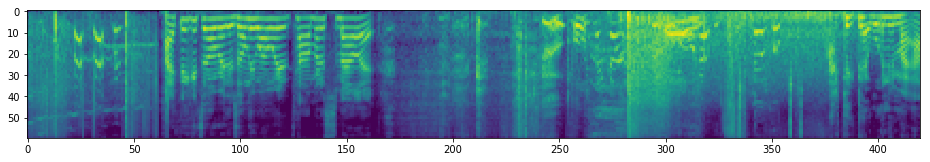

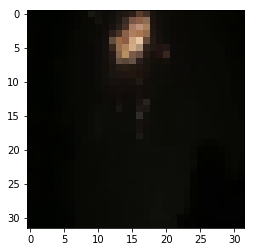

In [253]:
plt.figure(figsize=(16,5))
plt.imshow(audio_eval_x[14][:,:,-1])
plt.show()
plt.imshow(video_eval_x[14][0][:,:,::-1])

In [297]:
# usar para ver as ativações
#https://github.com/philipperemy/keras-visualize-activations

In [298]:
from utils import get_activations,display_activations

In [299]:
def display_activations(activation_maps):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        print(shape)
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 50:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            continue
        plt.imshow(activations, interpolation='None', cmap='jet')
        plt.show()

----- activations -----
(1, 60, 420, 1)
(1, 4, 415, 80)
(1, 4, 415, 80)
(1, 1, 138, 80)
(1, 1, 138, 80)
(1, 1, 138, 80)
(1, 1, 136, 80)
(1, 1, 136, 80)
(1, 1, 45, 80)
(1, 1, 45, 80)
(1, 3600)
(1, 5000)
(1, 5000)
(1, 5000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 7)
Displaying activation map 0
(1, 60, 420, 1)


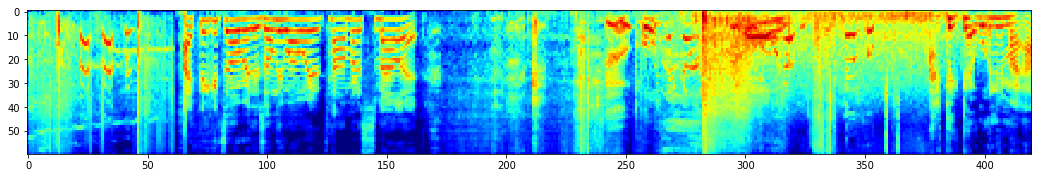

Displaying activation map 1
(1, 4, 415, 80)


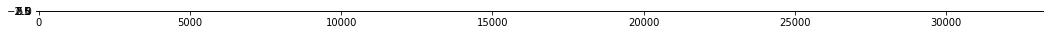

Displaying activation map 2
(1, 4, 415, 80)


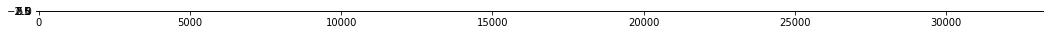

Displaying activation map 3
(1, 1, 138, 80)


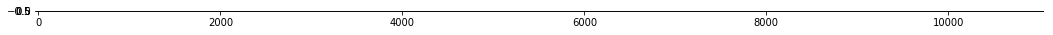

Displaying activation map 4
(1, 1, 138, 80)


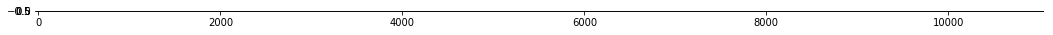

Displaying activation map 5
(1, 1, 138, 80)


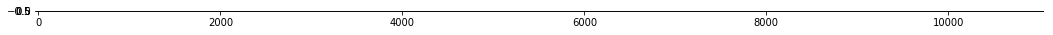

Displaying activation map 6
(1, 1, 136, 80)


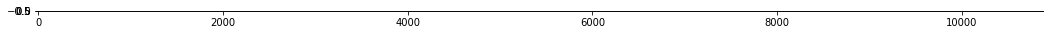

Displaying activation map 7
(1, 1, 136, 80)


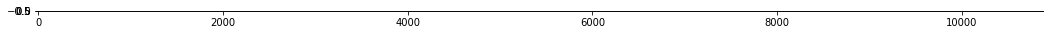

Displaying activation map 8
(1, 1, 45, 80)


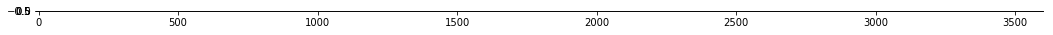

Displaying activation map 9
(1, 1, 45, 80)


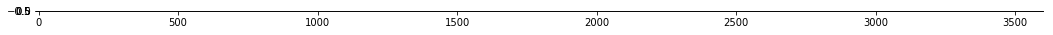

Displaying activation map 10
(1, 3600)


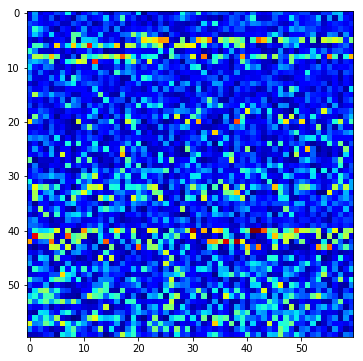

Displaying activation map 11
(1, 5000)


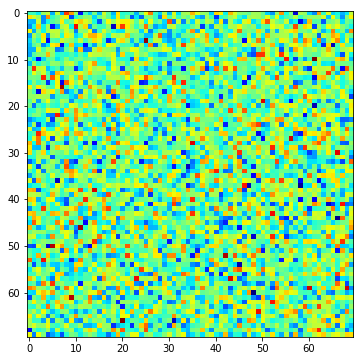

Displaying activation map 12
(1, 5000)


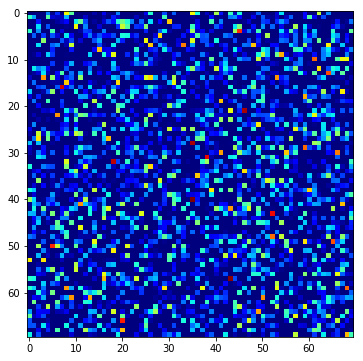

Displaying activation map 13
(1, 5000)


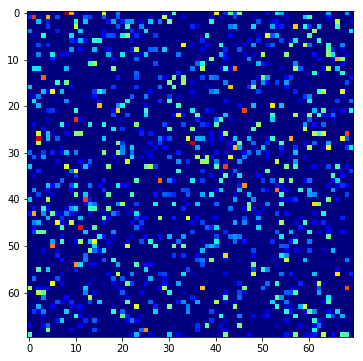

Displaying activation map 14
(1, 1000)


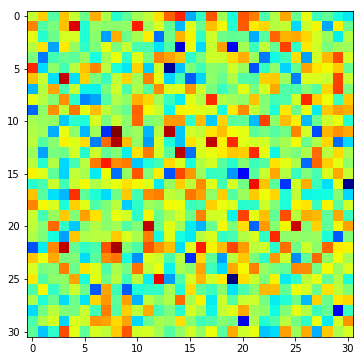

Displaying activation map 15
(1, 1000)


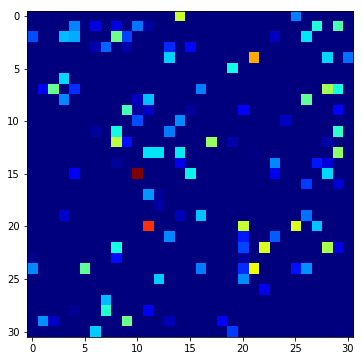

Displaying activation map 16
(1, 1000)


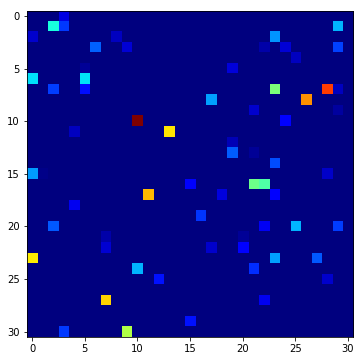

Displaying activation map 17
(1, 7)


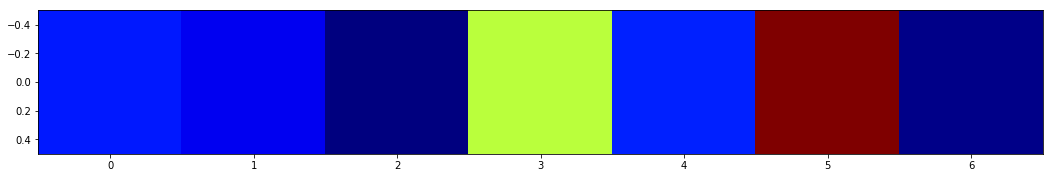

In [304]:
## get activations for the first example of the test set
activ = get_activations(audio_model, audio_eval_x[14:15])  # with just one sample.
display_activations(activ)

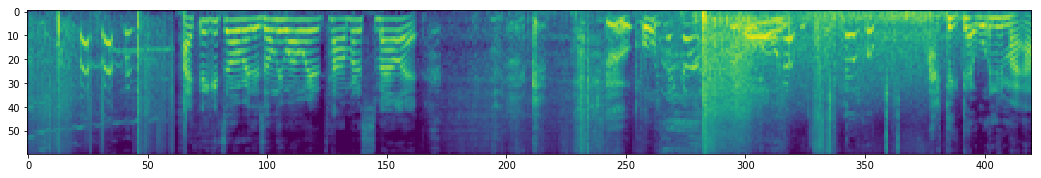

((1, 4, 415, 80), (415, 80))


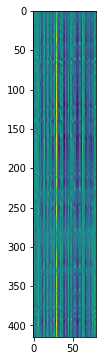

((1, 4, 415, 80), (415, 80))


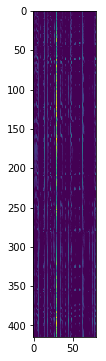

((1, 1, 138, 80), (138, 80))


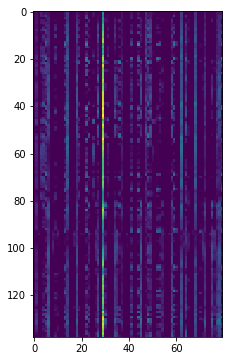

((1, 1, 138, 80), (138, 80))


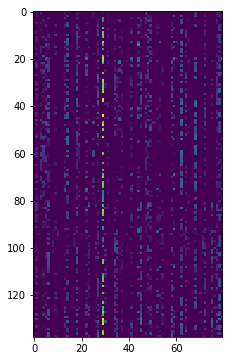

((1, 1, 138, 80), (138, 80))


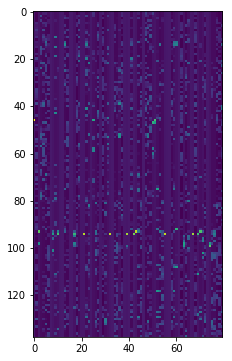

((1, 1, 136, 80), (136, 80))


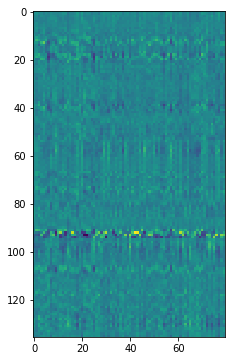

((1, 1, 136, 80), (136, 80))


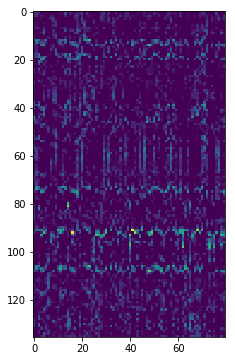

((1, 1, 45, 80), (45, 80))


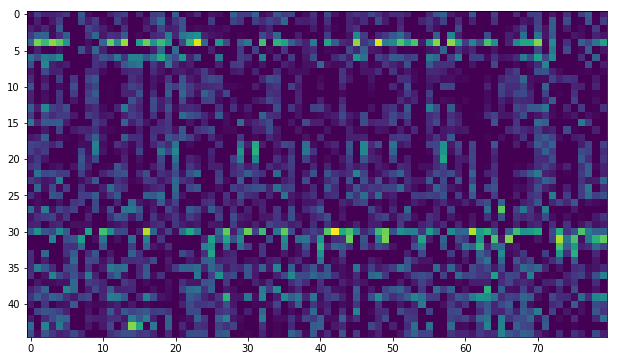

((1, 1, 45, 80), (45, 80))


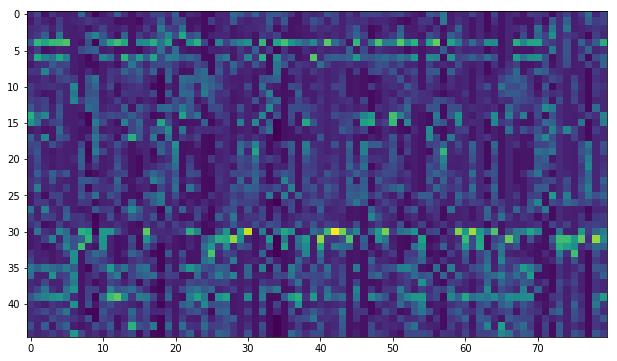

IndexError: too many indices for array

In [310]:
plt.imshow(activ[0][0,:,:,0])
plt.show()

for x in range(1,12):
    print(activ[x].shape,activ[x][0,0,:, :].shape)
    plt.imshow(activ[x][0,0,:, :])
    plt.show()

----- activations -----
(1, 32, 32, 32, 3)
(1, 32, 16, 16, 32)
(1, 32, 16, 16, 32)
(1, 32, 16, 16, 32)
(1, 32, 16, 16, 32)
(1, 32, 8, 8, 32)
(1, 32, 8, 8, 32)
(1, 32, 8, 8, 64)
(1, 32, 8, 8, 64)
(1, 32, 8, 8, 64)
(1, 32, 8, 8, 64)
(1, 32, 4, 4, 64)
(1, 32, 4, 4, 128)
(1, 32, 4, 4, 128)
(1, 32, 4, 4, 128)
(1, 32, 4, 4, 128)
(1, 32, 2, 2, 128)
(1, 32, 512)
(1, 256)
(1, 256)
(1, 1000)
(1, 1000)
(1, 7)
Displaying activation map 0
(1, 32, 32, 32, 3)
Displaying activation map 1
(1, 32, 16, 16, 32)
Displaying activation map 2
(1, 32, 16, 16, 32)
Displaying activation map 3
(1, 32, 16, 16, 32)
Displaying activation map 4
(1, 32, 16, 16, 32)
Displaying activation map 5
(1, 32, 8, 8, 32)
Displaying activation map 6
(1, 32, 8, 8, 32)
Displaying activation map 7
(1, 32, 8, 8, 64)
Displaying activation map 8
(1, 32, 8, 8, 64)
Displaying activation map 9
(1, 32, 8, 8, 64)
Displaying activation map 10
(1, 32, 8, 8, 64)
Displaying activation map 11
(1, 32, 4, 4, 64)
Displaying activation map 12
(1, 32

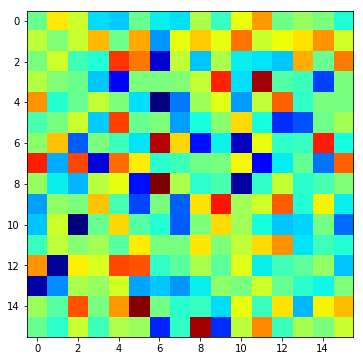

Displaying activation map 19
(1, 256)


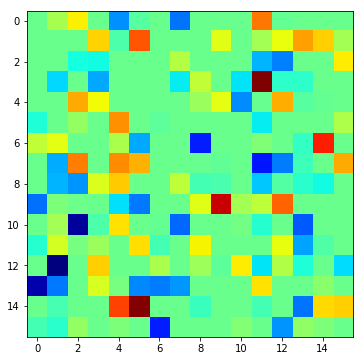

Displaying activation map 20
(1, 1000)


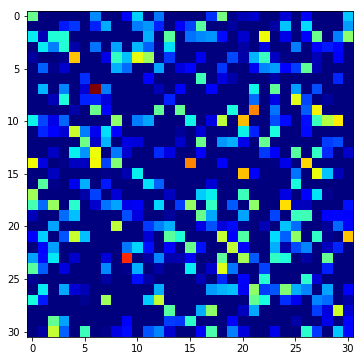

Displaying activation map 21
(1, 1000)


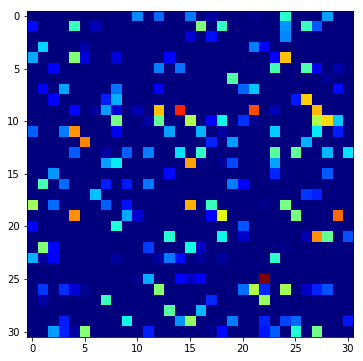

Displaying activation map 22
(1, 7)


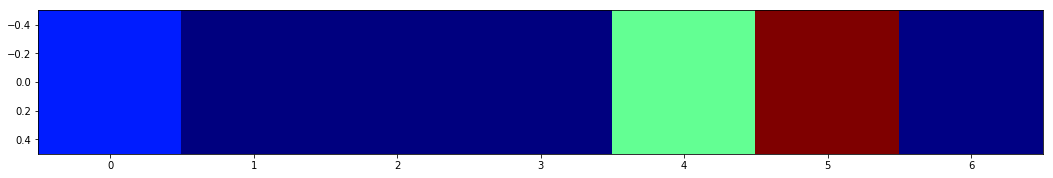

In [391]:
## get activations for the first example of the test set
activ = get_activations(video_model, video_eval_x[14:15])  # with just one sample.
display_activations(activ)

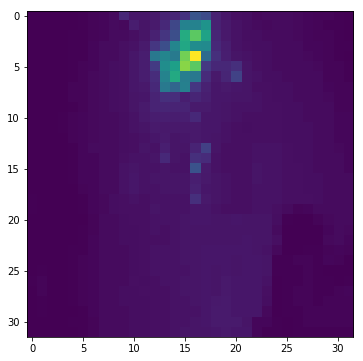

In [412]:
plt.imshow(activ[0][0,0,:,:,0])

----- activations -----
(1, 32, 32, 32, 3)
(1, 32, 16, 16, 32)
(1, 32, 16, 16, 32)
(1, 32, 16, 16, 32)
(1, 32, 16, 16, 32)
(1, 32, 8, 8, 32)
(1, 32, 8, 8, 32)
(1, 32, 8, 8, 64)
(1, 32, 8, 8, 64)
(1, 32, 8, 8, 64)
(1, 60, 420, 1)
(1, 32, 8, 8, 64)
(1, 4, 415, 80)
(1, 32, 4, 4, 64)
(1, 4, 415, 80)
(1, 32, 4, 4, 128)
(1, 1, 138, 80)
(1, 32, 4, 4, 128)
(1, 1, 138, 80)
(1, 32, 4, 4, 128)
(1, 1, 136, 80)
(1, 32, 4, 4, 128)
(1, 1, 136, 80)
(1, 32, 2, 2, 128)
(1, 1, 45, 80)
(1, 32, 512)
(1, 3600)
(1, 256)
(1, 5000)
(1, 256)
(1, 5000)
(1, 1000)
(1, 1000)
(1, 2000)
(1, 500)
(1, 500)
(1, 500)
(1, 500)
(1, 7)
Displaying activation map 0
(1, 32, 32, 32, 3)
Displaying activation map 1
(1, 32, 16, 16, 32)
Displaying activation map 2
(1, 32, 16, 16, 32)
Displaying activation map 3
(1, 32, 16, 16, 32)
Displaying activation map 4
(1, 32, 16, 16, 32)
Displaying activation map 5
(1, 32, 8, 8, 32)
Displaying activation map 6
(1, 32, 8, 8, 32)
Displaying activation map 7
(1, 32, 8, 8, 64)
Displaying activat

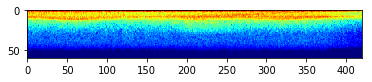

Displaying activation map 11
(1, 32, 8, 8, 64)
Displaying activation map 12
(1, 4, 415, 80)


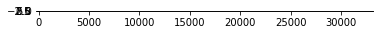

Displaying activation map 13
(1, 32, 4, 4, 64)
Displaying activation map 14
(1, 4, 415, 80)


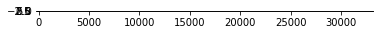

Displaying activation map 15
(1, 32, 4, 4, 128)
Displaying activation map 16
(1, 1, 138, 80)


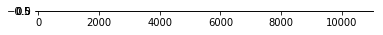

Displaying activation map 17
(1, 32, 4, 4, 128)
Displaying activation map 18
(1, 1, 138, 80)


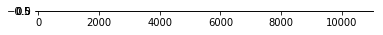

Displaying activation map 19
(1, 32, 4, 4, 128)
Displaying activation map 20
(1, 1, 136, 80)


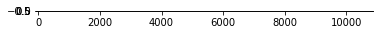

Displaying activation map 21
(1, 32, 4, 4, 128)
Displaying activation map 22
(1, 1, 136, 80)


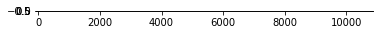

Displaying activation map 23
(1, 32, 2, 2, 128)
Displaying activation map 24
(1, 1, 45, 80)


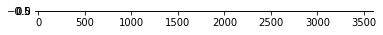

Displaying activation map 25
(1, 32, 512)
Displaying activation map 26
(1, 3600)


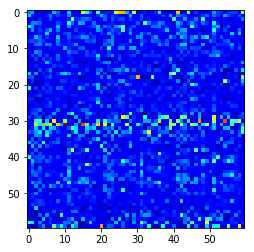

Displaying activation map 27
(1, 256)


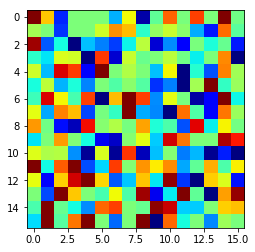

Displaying activation map 28
(1, 5000)


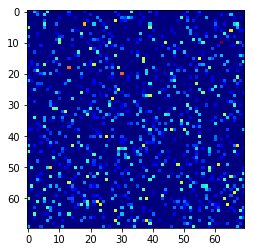

Displaying activation map 29
(1, 256)


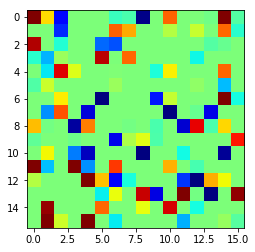

Displaying activation map 30
(1, 5000)


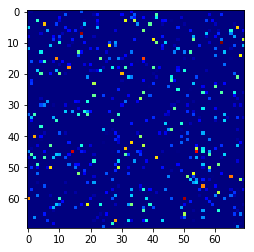

Displaying activation map 31
(1, 1000)


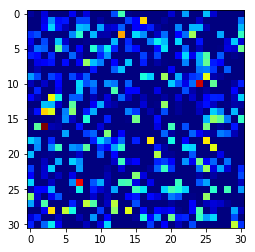

Displaying activation map 32
(1, 1000)


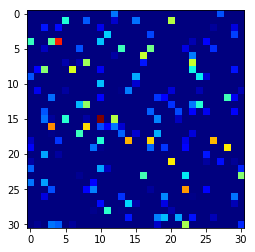

Displaying activation map 33
(1, 2000)


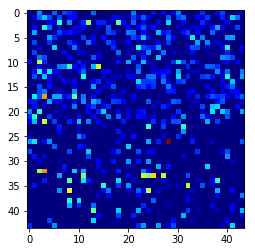

Displaying activation map 34
(1, 500)


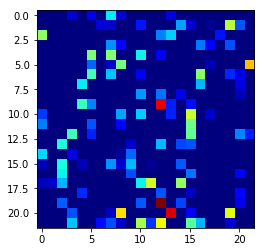

Displaying activation map 35
(1, 500)


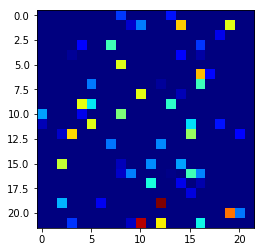

Displaying activation map 36
(1, 500)


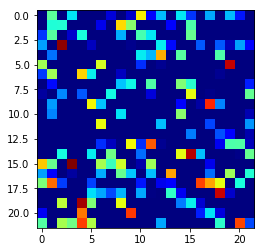

Displaying activation map 37
(1, 500)


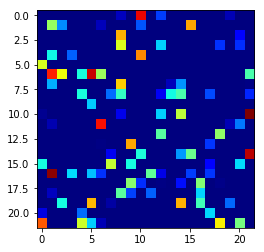

Displaying activation map 38
(1, 7)


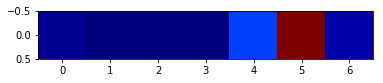

In [157]:
## get activations for the first example of the test set
activ = get_activations(multimodal_model, [video_eval_x[0:1],audio_eval_x[0:1]])  # with just one sample.
display_activations(activ)

In [46]:
labels = ["Wind","Thunder","Rain","Ocean","Fire","Explosion","Gunshot, gunfire"]
len(labels)

7